# Augmentation Strategies and Model Robustness
- Detect overfitting from training curves
- Apply geometric augmentation
- Apply color distortion
- Implement MixUp
- Compare validation performance across strategies
- Understand augmentation as regularization

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

# Load Dataset

(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

IMG_SIZE = (160, 160)
BATCH_SIZE = 32


TensorFlow version: 2.9.1


In [11]:
# Structural Preprocessing (Required for Batching)
# Even when augmentation is inside the model, we must resize before batching.

def resize_only(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

train_raw = (
    ds_train
    .map(resize_only)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_raw = (
    ds_val
    .map(resize_only)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


In [12]:
# Helper Function to Build Model

def build_model(data_augmentation=None):
    
    preprocessing = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255)
    ])
    
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(160, 160, 3),
        include_top=False,
        weights="imagenet"
    )
    
    base_model.trainable = False
    
    model_layers = []
    
    if data_augmentation:
        model_layers.append(data_augmentation)
    
    model_layers.extend([
        preprocessing,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    
    model = tf.keras.Sequential(model_layers)
    
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model


In [13]:
# Baseline Model (No Augmentation)

baseline_model = build_model()

history_baseline = baseline_model.fit(
    train_raw,
    validation_data=val_raw,
    epochs=5
)


Epoch 1/5
92/92 [==============================] - 17s 152ms/step - loss: 0.7635 - accuracy: 0.7163 - val_loss: 0.4609 - val_accuracy: 0.8474
Epoch 2/5
92/92 [==============================] - 12s 133ms/step - loss: 0.3793 - accuracy: 0.8716 - val_loss: 0.3883 - val_accuracy: 0.8638
Epoch 3/5
92/92 [==============================] - 12s 134ms/step - loss: 0.3006 - accuracy: 0.9022 - val_loss: 0.3378 - val_accuracy: 0.8774
Epoch 4/5
92/92 [==============================] - 12s 130ms/step - loss: 0.2511 - accuracy: 0.9172 - val_loss: 0.3279 - val_accuracy: 0.8842
Epoch 5/5
92/92 [==============================] - 13s 137ms/step - loss: 0.2155 - accuracy: 0.9343 - val_loss: 0.3137 - val_accuracy: 0.8937


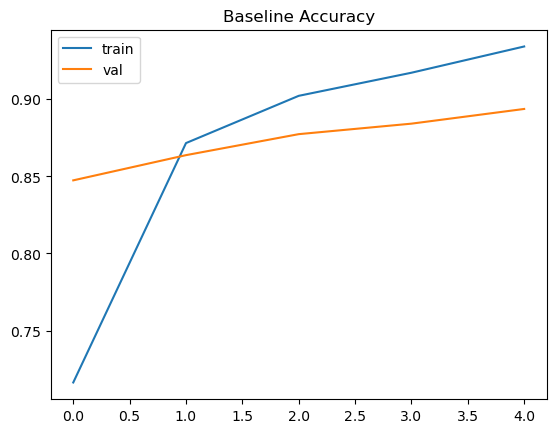

In [14]:
# Plot Baseline Performance
    
plt.plot(history_baseline.history["accuracy"], label="train")
plt.plot(history_baseline.history["val_accuracy"], label="val")
plt.legend()
plt.title("Baseline Accuracy")
plt.show()


# Discussion
- Is there a gap between training and validation?
- Are we overfitting?

In [15]:
# Geometric Augmentation

geo_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

geo_model = build_model(data_augmentation=geo_augmentation)

history_geo = geo_model.fit(
    train_raw,
    validation_data=val_raw,
    epochs=5
)


Epoch 1/5
92/92 [==============================] - 19s 160ms/step - loss: 0.8529 - accuracy: 0.6754 - val_loss: 0.4852 - val_accuracy: 0.8351
Epoch 2/5
92/92 [==============================] - 14s 153ms/step - loss: 0.4739 - accuracy: 0.8348 - val_loss: 0.4022 - val_accuracy: 0.8488
Epoch 3/5
92/92 [==============================] - 15s 165ms/step - loss: 0.3994 - accuracy: 0.8518 - val_loss: 0.3736 - val_accuracy: 0.8610
Epoch 4/5
92/92 [==============================] - 15s 160ms/step - loss: 0.3483 - accuracy: 0.8801 - val_loss: 0.3967 - val_accuracy: 0.8610
Epoch 5/5
92/92 [==============================] - 15s 165ms/step - loss: 0.3281 - accuracy: 0.8835 - val_loss: 0.3613 - val_accuracy: 0.8665


In [16]:
# Add Color Distortion

color_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

color_model = build_model(data_augmentation=color_augmentation)

history_color = color_model.fit(
    train_raw,
    validation_data=val_raw,
    epochs=5
)


Epoch 1/5


92/92 [==============================] - 22s 173ms/step - loss: 0.8403 - accuracy: 0.6856 - val_loss: 0.5302 - val_accuracy: 0.8079
Epoch 2/5
92/92 [==============================] - 16s 169ms/step - loss: 0.4733 - accuracy: 0.8300 - val_loss: 0.4080 - val_accuracy: 0.8610
Epoch 3/5
92/92 [==============================] - 16s 175ms/step - loss: 0.3980 - accuracy: 0.8597 - val_loss: 0.3744 - val_accuracy: 0.8610
Epoch 4/5
92/92 [==============================] - 16s 172ms/step - loss: 0.3525 - accuracy: 0.8832 - val_loss: 0.3570 - val_accuracy: 0.8760
Epoch 5/5
92/92 [==============================] - 15s 167ms/step - loss: 0.3235 - accuracy: 0.8832 - val_loss: 0.3338 - val_accuracy: 0.8815


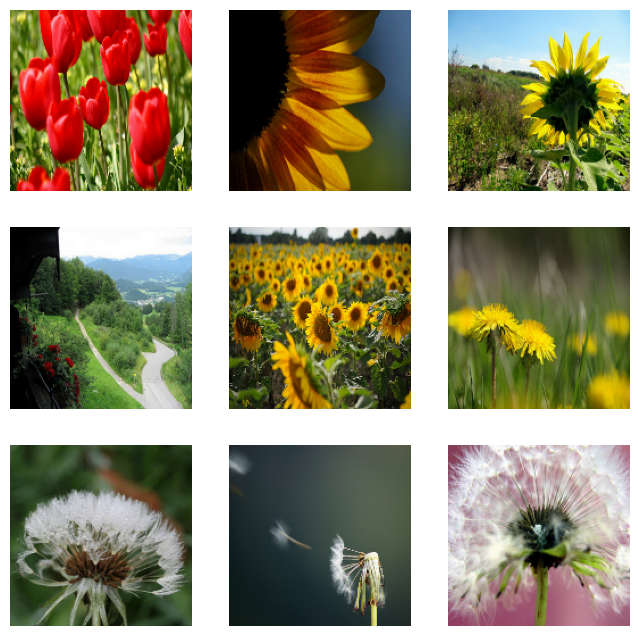

In [17]:
# Visualize Geometric + Color Augmentations 

import matplotlib.pyplot as plt

def show_augmented_images(dataset, augmentation_layer, num_images=9):
    plt.figure(figsize=(8, 8))
    
    for i, (image, label) in enumerate(dataset.take(num_images)):
        augmented_image = augmentation_layer(tf.expand_dims(image, 0))
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.cast(augmented_image[0], tf.uint8))
        plt.axis('off')
    
    plt.show()

# Example: Show geometric + color augmentations
augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Visualize first few images from the raw training dataset
show_augmented_images(ds_train.map(resize_only), augmentation_layer)


In [18]:
# Implement MixUp (Advanced Section - MixUp requires one-hot labels)

def to_one_hot(image, label):
    label = tf.one_hot(label, depth=num_classes)
    label = tf.cast(label, tf.float32)
    return image, label

# Convert train to one-hot
train_one_hot = (
    ds_train
    .map(resize_only)
    .map(to_one_hot)
    .shuffle(1000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

# Convert val to one-hot
val_one_hot = (
    ds_val
    .map(resize_only)
    .map(to_one_hot)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

def mixup(dataset, alpha=0.2):

    def _mixup(images, labels):
        batch_size = tf.shape(images)[0]

        # Sample lambda from Beta distribution
        lam = np.random.beta(alpha, alpha)
        lam = tf.cast(lam, tf.float32)

        # Shuffle within batch
        indices = tf.random.shuffle(tf.range(batch_size))
        shuffled_images = tf.gather(images, indices)
        shuffled_labels = tf.gather(labels, indices)

        # Mix images
        mixed_images = lam * images + (1 - lam) * shuffled_images

        # Mix labels
        mixed_labels = lam * labels + (1 - lam) * shuffled_labels

        return mixed_images, mixed_labels

    return dataset.map(_mixup, num_parallel_calls=tf.data.AUTOTUNE)


# MixUp
mixed_train = mixup(train_one_hot)

# Build model
mixup_model = build_model()
mixup_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  # one-hot labels
    metrics=["accuracy"]
)

# Train
history_mixup = mixup_model.fit(
    mixed_train,
    validation_data=val_one_hot,
    epochs=5
)


Epoch 1/5
91/91 [==============================] - 17s 150ms/step - loss: 1.3271 - accuracy: 0.5999 - val_loss: 0.6933 - val_accuracy: 0.7741
Epoch 2/5
91/91 [==============================] - 13s 138ms/step - loss: 1.1321 - accuracy: 0.7397 - val_loss: 0.5752 - val_accuracy: 0.8366
Epoch 3/5
91/91 [==============================] - 12s 136ms/step - loss: 1.0990 - accuracy: 0.7548 - val_loss: 0.5839 - val_accuracy: 0.8253
Epoch 4/5
91/91 [==============================] - 13s 137ms/step - loss: 1.0654 - accuracy: 0.7685 - val_loss: 0.5492 - val_accuracy: 0.8324
Epoch 5/5
91/91 [==============================] - 13s 137ms/step - loss: 1.0648 - accuracy: 0.7840 - val_loss: 0.5642 - val_accuracy: 0.8395


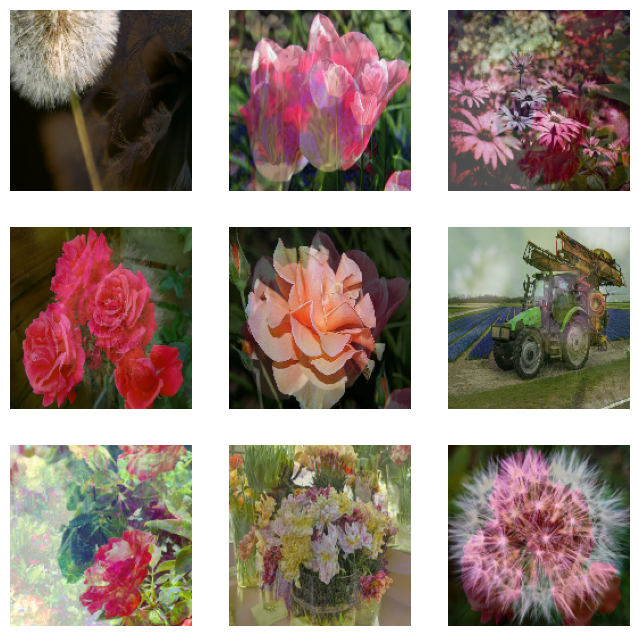

In [19]:
# Visualize MixUp

import matplotlib.pyplot as plt
import tensorflow as tf

def show_mixup_samples(mixed_dataset, num_images=9):
    plt.figure(figsize=(8, 8))
    
    images_plotted = 0
    for batch_images, batch_labels in mixed_dataset:
        for i in range(batch_images.shape[0]):
            plt.subplot(3, 3, images_plotted + 1)
            plt.imshow(tf.cast(batch_images[i], tf.uint8))
            plt.axis('off')
            
            images_plotted += 1
            if images_plotted >= num_images:
                break
        if images_plotted >= num_images:
            break
    
    plt.show()

# Display first 9 MixUp images
show_mixup_samples(mixed_train)
